<a href="https://colab.research.google.com/github/AFynjy/AFynjy.gifthub.io/blob/master/2_2_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# импортируем бэкенд Agg из matplotlib для сохранения графиков на диск
import matplotlib
matplotlib.use("Agg")

In [ ]:
# Подключаем необходимые модули и пакеты
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
from google.colab.patches import cv2_imshow
import os

In [ ]:
# инициализируем данные и метки
print("[INFO] loading images...")
data = []
labels = []

[INFO] loading images...


In [ ]:
# Собираем список путей к каждому изображению и перемешиваем их
imagePaths = sorted(list(paths.list_images("/content/Dataset")))

random.shuffle(imagePaths)

In [ ]:
# цикл по изображениям
for imagePath in imagePaths:
	
	image = cv2.imread(imagePath) # загружаем изображение
	image = cv2.resize(image, (32, 32)).flatten() # меняем его разрешение на 32x32 пикселей (без учета соотношения сторон),
																								# сглаживаем его в 32x32x3=3072 пикселей
	data.append(image) # добавляем в список

	label = imagePath.split(os.path.sep)[-2] 	# извлекаем метку класса из пути к изображению (метка класса зависит от имени папки)
	labels.append(label) # обновляем список меток

In [ ]:
# масштабируем интенсивности пикселей в диапазон [0, 1] (Нормализация данных)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [ ]:
# разбиваем данные на обучающую и тестовую выборки, используя 75%
# данных для обучения и оставшиеся 25% для тестирования
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

In [ ]:
# конвертируем метки из целых чисел в векторы (для 2х классов при
# бинарной классификации вам следует использовать функцию Keras
# "to_categorical" вместо "LabelBinarizer" из scikit-learn, которая не возвращает вектор)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [ ]:
# определим архитектуру 3072-1024-512-3 с помощью Keras
model = Sequential()
model.add(Dense(1024, input_shape=(3072,), activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

In [ ]:
# инициализируем скорость обучения и общее число эпох
INIT_LR = 0.01
EPOCHS = 80

In [ ]:
# компилируем модель, используя SGD как оптимизатор и категориальную
# кросс-энтропию в качестве функции потерь (для бинарной классификации
# следует использовать binary_crossentropy)
print("[INFO] training network...")
opt = SGD(lr=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer='adam',
	metrics=["accuracy"])

[INFO] training network...


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# обучаем нейросеть
H = model.fit(trainX, trainY, validation_data=(testX, testY),
	epochs=EPOCHS, batch_size=1000)

Epoch 1/80
3/3 [==============================] - 2s 301ms/step - loss: 5.3262 - accuracy: 0.3427 - val_loss: 1.5382 - val_accuracy: 0.3400
Epoch 2/80
3/3 [==============================] - 1s 198ms/step - loss: 1.5622 - accuracy: 0.3307 - val_loss: 1.6304 - val_accuracy: 0.3240
Epoch 3/80
3/3 [==============================] - 1s 212ms/step - loss: 1.3433 - accuracy: 0.3556 - val_loss: 1.3415 - val_accuracy: 0.3440
Epoch 4/80
3/3 [==============================] - 1s 189ms/step - loss: 1.1801 - accuracy: 0.4076 - val_loss: 1.0892 - val_accuracy: 0.4107
Epoch 5/80
3/3 [==============================] - 1s 229ms/step - loss: 1.0724 - accuracy: 0.3933 - val_loss: 0.9903 - val_accuracy: 0.4760
Epoch 6/80
3/3 [==============================] - 1s 192ms/step - loss: 1.0100 - accuracy: 0.4738 - val_loss: 1.0050 - val_accuracy: 0.5027
Epoch 7/80
3/3 [==============================] - 1s 194ms/step - loss: 0.9652 - accuracy: 0.5098 - val_loss: 1.0281 - val_accuracy: 0.4640
Epoch 8/80
3/3 [====

In [ ]:
# оцениваем нейросеть
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
24/24 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

        cats       0.60      0.58      0.59       253
        dogs       0.49      0.57      0.53       242
      pandas       0.84      0.73      0.78       255

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.63       750
weighted avg       0.65      0.63      0.64       750



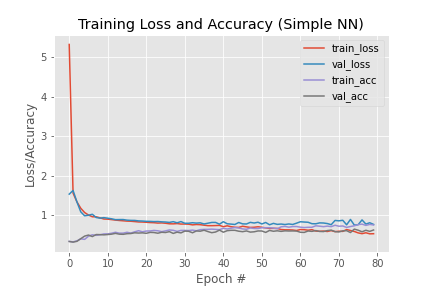

In [ ]:
# строим графики потерь и точности
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('plot.png')
cv2_imshow(cv2.imread("plot.png"))

In [ ]:
# сохраняем модель и метки классов в бинарном представлении на диск
print("[INFO] serializing network and label binarizer...")
model.save("model.h5", save_format="h5")
f = open("label_bin", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing network and label binarizer...


In [ ]:
from keras.models import load_model
import argparse
import pickle
import cv2

Saving Panda_closeup.jpg to Panda_closeup.jpg


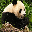

In [ ]:
# Добавляем интерфейс для загрузки изображений напрямую из блокнота
from google.colab import files
uploaded = files.upload() 

# загружаем входное изображение, меняем его размер на необходимый и выводим его
image = cv2.imread(list(uploaded.keys())[0])
output = image.copy()
image = cv2.resize(image, (32, 32))
cv2_imshow(image)

In [ ]:
# "Выравниваем" изображение (преобразуем его в вектор. Из 32х32х3 -> 3072)
image = image.flatten()
# масштабируем значения пикселей к диапазону [0, 1]
image = image.astype("float") / 255.0
image = image.reshape((1, image.shape[0]))

In [ ]:
# загружаем модель и бинаризатор меток
from keras import models    
print("[INFO] loading network and label binarizer...")
model = models.load_model("model.h5")
lb = pickle.loads(open("label_bin", "rb").read())

[INFO] loading network and label binarizer...


In [ ]:
# делаем предсказание на изображении
preds = model.predict(image)
print(preds)

1/1 [==============================] - 0s 64ms/step
[[6.700679e-05 5.219378e-04 9.994111e-01]]


In [ ]:
# находим индекс метки класса с наибольшей вероятностью
# соответствия
i = preds.argmax(axis=1)[0]
label = lb.classes_[i]

In [ ]:
# Добавляем на исходное изображение метку класса и вероятность прогноза
text = "{}: {:.2f}%".format(label, preds[0][i] * 100)
cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
	(0, 0, 255), 2)

array([[[152, 197, 178],
        [122, 167, 148],
        [116, 161, 144],
        ...,
        [124, 131, 128],
        [119, 133, 129],
        [120, 135, 131]],

       [[ 47,  89,  71],
        [  5,  50,  31],
        [  0,  45,  28],
        ...,
        [  0,   2,   0],
        [  0,   3,   0],
        [  0,  11,   7]],

       [[ 76, 114,  96],
        [ 31,  71,  53],
        [ 36,  81,  64],
        ...,
        [  0,  10,   7],
        [  8,  26,  19],
        [ 21,  42,  34]],

       ...,

       [[ 41,  97,  98],
        [ 40,  93,  96],
        [ 35,  81,  88],
        ...,
        [ 61,  89, 119],
        [ 81, 109, 139],
        [ 97, 125, 155]],

       [[ 45,  97,  97],
        [ 35,  85,  85],
        [ 17,  59,  64],
        ...,
        [ 79, 110, 135],
        [ 66,  96, 123],
        [ 42,  72,  99]],

       [[ 16,  56,  55],
        [ 29,  67,  67],
        [ 31,  63,  68],
        ...,
        [ 64, 100, 118],
        [ 69, 105, 123],
        [ 75, 111, 129]]

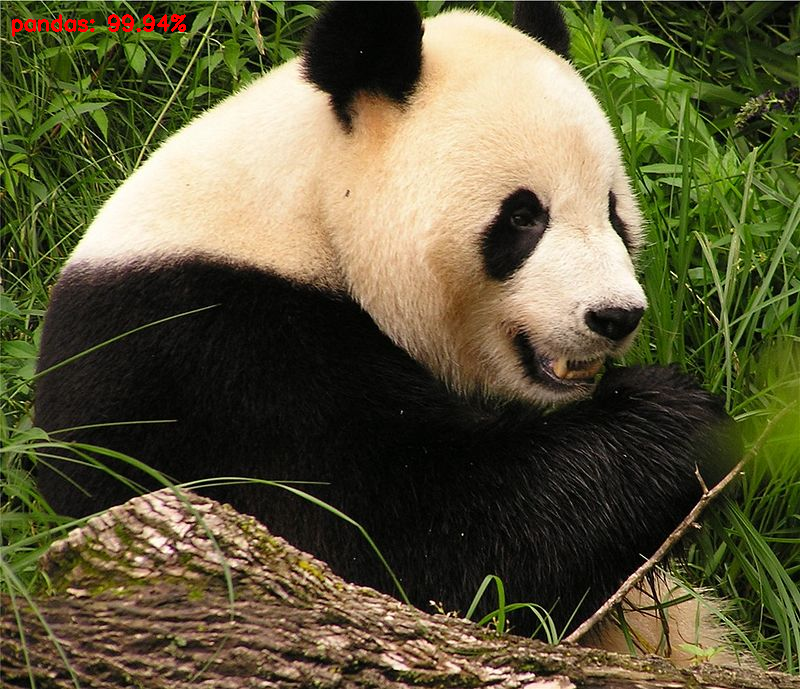

In [ ]:
# показываем выходное изображение
cv2_imshow(output)